# Milwaukee Transportation Network Analysis

Comprehensive analysis of the Milwaukee transportation network including network characteristics,
accessibility metrics, equity analysis, and performance indicators.

**Contents:**
1. Setup and Data Loading
2. Network Characteristics
3. Network Connectivity Analysis
4. Demand Analysis (OD Matrices)
5. Accessibility Metrics
6. Equity Analysis (Gini Coefficient)
7. Network Visualization
8. Performance Metrics
9. Summary and Key Findings

## 1. Setup and Data Loading

### 1.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import LineString, Point
from shapely import wkt
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"GeoPandas version: {gpd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 2.2.3
GeoPandas version: 1.0.1
NumPy version: 1.26.4


### 1.2 Load Network Data

In [2]:
# Load node data
nodes_df = pd.read_csv('../data/node.csv')
print(f"Loaded {len(nodes_df)} nodes")
print("\nFirst 5 nodes:")
print(nodes_df.head())
print("\nNode DataFrame Info:")
print(nodes_df.info())

Loaded 8521 nodes

First 5 nodes:
   node_id  zone_id    x_coord    y_coord  \
0        1      1.0 -87.888534  42.996472   
1        2      2.0 -87.897396  43.004612   
2        3      3.0 -87.941012  42.986585   
3        4      4.0 -87.905384  42.998823   
4        5      5.0 -87.905679  42.992777   

                                        geometry  
0   POINT (-87.88853371142858 42.99647218857143)  
1   POINT (-87.89739580689655 43.00461247356321)  
2             POINT (-87.941011752 42.986585192)  
3         POINT (-87.90538432250001 42.99882289)  
4  POINT (-87.90567903913043 42.992776747826085)  

Node DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   node_id   8521 non-null   int64  
 1   zone_id   234 non-null    float64
 2   x_coord   8521 non-null   float64
 3   y_coord   8521 non-null   float64
 4   geometry  8521 non-nul

In [3]:
# Load link data
links_df = pd.read_csv('../data/link.csv')
print(f"Loaded {len(links_df)} links")
print("\nFirst 5 links:")
print(links_df.head())
print("\nLink DataFrame Info:")
print(links_df.info())

Loaded 30747 links

First 5 links:
   link_id  from_node_id  to_node_id  dir_flag  length  vdf_length_mi  \
0    25311             1        1185         1     0.0            0.0   
1    25578             1        1186         1     0.0            0.0   
2    25313             1        1187         1     0.0            0.0   
3    25580             1        1427         1     0.0            0.0   
4    25582             1        1428         1     0.0            0.0   

   free_speed  vdf_free_speed_mph  vdf_fftt  vdf_toll  link_type  vdf_alpha  \
0          15            9.320568       0.0         0          0        0.5   
1          15            9.320568       0.0         0          0        0.5   
2          15            9.320568       0.0         0          0        0.5   
3          15            9.320568       0.0         0          0        0.5   
4          15            9.320568       0.0         0          0        0.5   

   vdf_beta  vdf_plf  lanes  capacity  ref_volume  

### 1.3 Load Demand Data

In [4]:
# Load demand (OD) data
demand_df = pd.read_csv('../data/demand.csv')
print(f"Loaded {len(demand_df)} OD pairs")
print(f"Total demand: {demand_df['volume'].sum():,.0f} trips")
print("\nFirst 10 OD pairs:")
print(demand_df.head(10))
print("\nDemand statistics:")
print(demand_df['volume'].describe())

Loaded 30422 OD pairs
Total demand: 163,700 trips

First 10 OD pairs:
   o_zone_id  d_zone_id  volume
0          1          2      12
1          1          3       3
2          1          4       5
3          1          5       1
4          1          6       1
5          1          7      11
6          1          8       1
7          1          9       6
8          1         10       3
9          1         12       1

Demand statistics:
count    30422.000000
mean         5.380974
std          9.882363
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        202.000000
Name: volume, dtype: float64


### 1.4 Load Accessibility Data

In [5]:
# Load accessibility data
origin_access = pd.read_csv('../data/origin_accessibility.csv')
destination_access = pd.read_csv('../data/destination_accessibility.csv')

print(f"Loaded accessibility data for {len(origin_access)} origin zones")
print(f"Loaded accessibility data for {len(destination_access)} destination zones")

print("\nOrigin Accessibility (first 10 zones):")
print(origin_access.head(10))

print("\nDestination Accessibility (first 10 zones):")
print(destination_access.head(10))

Loaded accessibility data for 234 origin zones
Loaded accessibility data for 234 destination zones

Origin Accessibility (first 10 zones):
   origin_zone_id  total_volume  number_of_destinations  avg_distance_mile  \
0               1           528                     108            4.55748   
1               2           909                     132            3.76632   
2               3           788                     137            4.55713   
3               4           882                     136            3.95933   
4               5           484                     102            3.99077   
5               6          1296                     144            5.56738   
6               7          1389                     159            7.00749   
7               8           668                     107            3.88177   
8               9           837                     112            3.78705   
9              10          1164                     141            3.51260   

  

## 2. Network Characteristics

In [6]:
# Network summary statistics
print("=" * 60)
print("MILWAUKEE TRANSPORTATION NETWORK SUMMARY")
print("=" * 60)
print(f"\nNetwork Size:")
print(f"  - Total Nodes: {len(nodes_df):,}")
print(f"  - Total Links: {len(links_df):,}")
print(f"  - Total Zones: {nodes_df['zone_id'].nunique():,}")

print(f"\nLink Characteristics:")
print(f"  - Total Length: {links_df['length'].sum():,.2f} units")
print(f"  - Average Link Length: {links_df['length'].mean():.2f} units")
print(f"  - Total Capacity: {links_df['capacity'].sum():,.0f} veh/h")
print(f"  - Average Capacity: {links_df['capacity'].mean():,.0f} veh/h")
print(f"  - Average Free Speed: {links_df['free_speed'].mean():.2f} units/h")
print(f"  - Total Lanes: {links_df['lanes'].sum():,.0f}")

print(f"\nDemand Summary:")
print(f"  - Total OD Pairs: {len(demand_df):,}")
print(f"  - Total Trips: {demand_df['volume'].sum():,.0f}")
print(f"  - Average Trips per OD: {demand_df['volume'].mean():.2f}")
print(f"  - Max Trips (single OD): {demand_df['volume'].max():,.0f}")
print("=" * 60)

MILWAUKEE TRANSPORTATION NETWORK SUMMARY

Network Size:
  - Total Nodes: 8,521
  - Total Links: 30,747
  - Total Zones: 234

Link Characteristics:
  - Total Length: 1,616,672.29 units
  - Average Link Length: 52.58 units
  - Total Capacity: 1,679,561,026 veh/h
  - Average Capacity: 54,625 veh/h
  - Average Free Speed: 31.77 units/h
  - Total Lanes: 35,098

Demand Summary:
  - Total OD Pairs: 30,422
  - Total Trips: 163,700
  - Average Trips per OD: 5.38
  - Max Trips (single OD): 202


In [7]:
# Link statistics by type
print("\nLink Statistics by Type:")
print(links_df.groupby('link_type').agg({
    'link_id': 'count',
    'length': ['sum', 'mean'],
    'capacity': ['sum', 'mean'],
    'lanes': 'sum',
    'free_speed': 'mean'
}).round(2))


Link Statistics by Type:
          link_id     length            capacity           lanes free_speed
            count        sum    mean         sum     mean    sum       mean
link_type                                                                  
0           16574       0.00    0.00  1657383426  99999.0  16574       15.0
1             675  218131.35  323.16     1485000   2200.0   2025       90.0
2              13     763.20   58.71       28600   2200.0     39       90.0
3            2975  293250.48   98.57     5950000   2000.0   5950       65.0
4            4915  479376.48   97.53     6881000   1400.0   4915       45.0
5            5595  625150.78  111.73     7833000   1400.0   5595       45.0


## 3. Network Connectivity Analysis

In [8]:
# Node degree distribution (connectivity)
node_out_degree = links_df.groupby('from_node_id').size()
node_in_degree = links_df.groupby('to_node_id').size()

print("\nNode Connectivity (Degree Distribution):")
print(f"Average Out-Degree: {node_out_degree.mean():.2f}")
print(f"Max Out-Degree: {node_out_degree.max()}")
print(f"Average In-Degree: {node_in_degree.mean():.2f}")
print(f"Max In-Degree: {node_in_degree.max()}")


Node Connectivity (Degree Distribution):
Average Out-Degree: 3.61
Max Out-Degree: 109
Average In-Degree: 3.61
Max In-Degree: 109


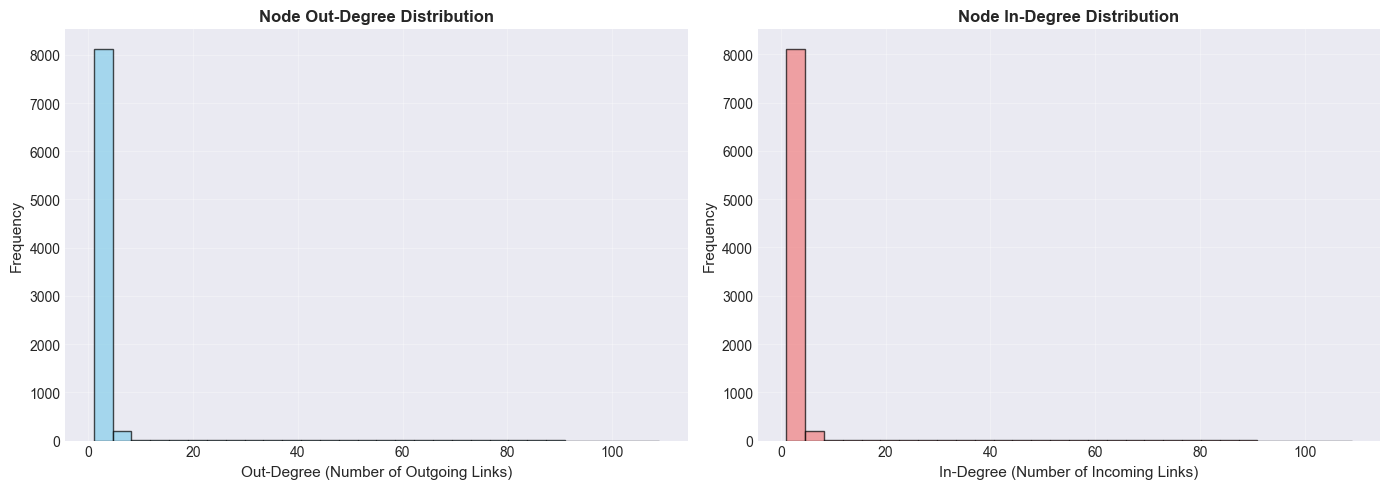

In [9]:
# Visualize node degree distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(node_out_degree, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Out-Degree (Number of Outgoing Links)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Node Out-Degree Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(node_in_degree, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('In-Degree (Number of Incoming Links)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Node In-Degree Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Demand Analysis (OD Matrices)

In [10]:
# Analyze OD patterns
print("=" * 70)
print("ORIGIN-DESTINATION MATRIX ANALYSIS")
print("=" * 70)

# Top OD pairs by volume
print("\nTop 20 OD Pairs by Volume:")
top_od = demand_df.nlargest(20, 'volume')[['o_zone_id', 'd_zone_id', 'volume']]
print(top_od.to_string(index=False))

# Origin and destination statistics
print(f"\nOrigin Statistics:")
origin_totals = demand_df.groupby('o_zone_id')['volume'].sum().sort_values(ascending=False)
print(f"  - Number of origin zones: {len(origin_totals)}")
print(f"  - Top 5 origins by outbound volume:")
for zone, vol in origin_totals.head(5).items():
    print(f"      Zone {zone}: {vol:,.0f} trips")

print(f"\nDestination Statistics:")
dest_totals = demand_df.groupby('d_zone_id')['volume'].sum().sort_values(ascending=False)
print(f"  - Number of destination zones: {len(dest_totals)}")
print(f"  - Top 5 destinations by inbound volume:")
for zone, vol in dest_totals.head(5).items():
    print(f"      Zone {zone}: {vol:,.0f} trips")

print("=" * 70)

ORIGIN-DESTINATION MATRIX ANALYSIS

Top 20 OD Pairs by Volume:
 o_zone_id  d_zone_id  volume
         7         67     202
        48         49     181
       220         67     161
        49         48     156
        14         49     153
       139         67     153
        47         49     152
        19         49     149
       190         67     148
        67         49     146
       206         67     137
        82         41     136
        46         49     135
        10         49     134
       193         67     124
         2         49     123
         9         49     123
        10         48     121
        10         67     120
        82         67     120

Origin Statistics:
  - Number of origin zones: 234
  - Top 5 origins by outbound volume:
      Zone 82: 1,606 trips
      Zone 145: 1,480 trips
      Zone 206: 1,473 trips
      Zone 216: 1,461 trips
      Zone 220: 1,449 trips

Destination Statistics:
  - Number of destination zones: 234
  - Top 5 destin

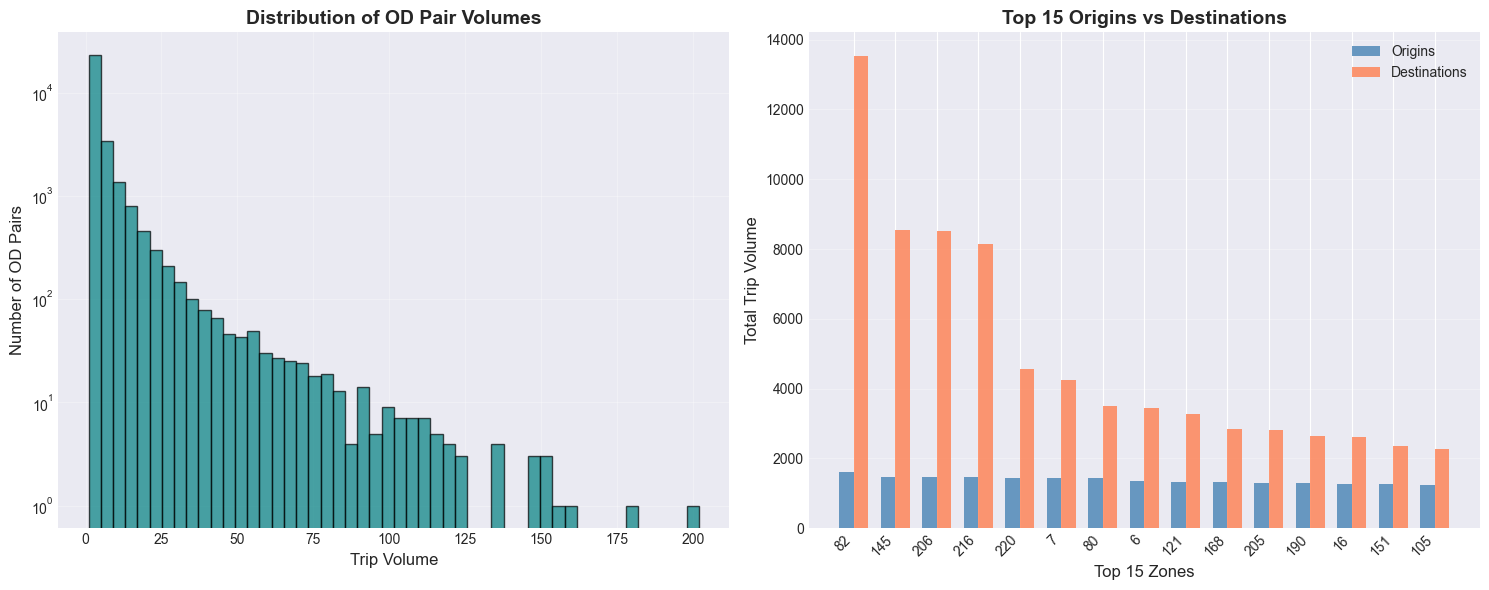

In [11]:
# Visualize OD volume distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of trip volumes
axes[0].hist(demand_df['volume'], bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Trip Volume', fontsize=12)
axes[0].set_ylabel('Number of OD Pairs', fontsize=12)
axes[0].set_title('Distribution of OD Pair Volumes', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')  # Log scale to see distribution better

# Top origins and destinations
top_n = 15
top_origins = demand_df.groupby('o_zone_id')['volume'].sum().nlargest(top_n)
top_dests = demand_df.groupby('d_zone_id')['volume'].sum().nlargest(top_n)

x_pos = np.arange(top_n)
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, top_origins.values, width, label='Origins', color='steelblue', alpha=0.8)
bars2 = axes[1].bar(x_pos + width/2, top_dests.values, width, label='Destinations', color='coral', alpha=0.8)

axes[1].set_xlabel(f'Top {top_n} Zones', fontsize=12)
axes[1].set_ylabel('Total Trip Volume', fontsize=12)
axes[1].set_title(f'Top {top_n} Origins vs Destinations', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(top_origins.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Accessibility Metrics

In [12]:
# Accessibility summary statistics
print("=" * 70)
print("ACCESSIBILITY METRICS SUMMARY")
print("=" * 70)

print("\nORIGIN ACCESSIBILITY (Ease of leaving zones):")
print(f"  Average destinations reachable: {origin_access['number_of_destinations'].mean():.2f}")
print(f"  Average distance (miles): {origin_access['avg_distance_mile'].mean():.2f}")
print(f"  Average travel time (min): {origin_access['avg_travel_time_min'].mean():.2f}")
print(f"  Total outbound volume: {origin_access['total_volume'].sum():,.0f}")

print("\nDESTINATION ACCESSIBILITY (Attractiveness of zones):")
print(f"  Average origins connecting: {destination_access['number_of_origins'].mean():.2f}")
print(f"  Average distance (miles): {destination_access['avg_distance_mile'].mean():.2f}")
print(f"  Average travel time (min): {destination_access['avg_travel_time_min'].mean():.2f}")
print(f"  Total inbound volume: {destination_access['total_volume'].sum():,.0f}")
print("=" * 70)

ACCESSIBILITY METRICS SUMMARY

ORIGIN ACCESSIBILITY (Ease of leaving zones):
  Average destinations reachable: 124.06
  Average distance (miles): 4.99
  Average travel time (min): 16.73
  Total outbound volume: 156,930

DESTINATION ACCESSIBILITY (Attractiveness of zones):
  Average origins connecting: 124.06
  Average distance (miles): 4.77
  Average travel time (min): 14.93
  Total inbound volume: 156,930


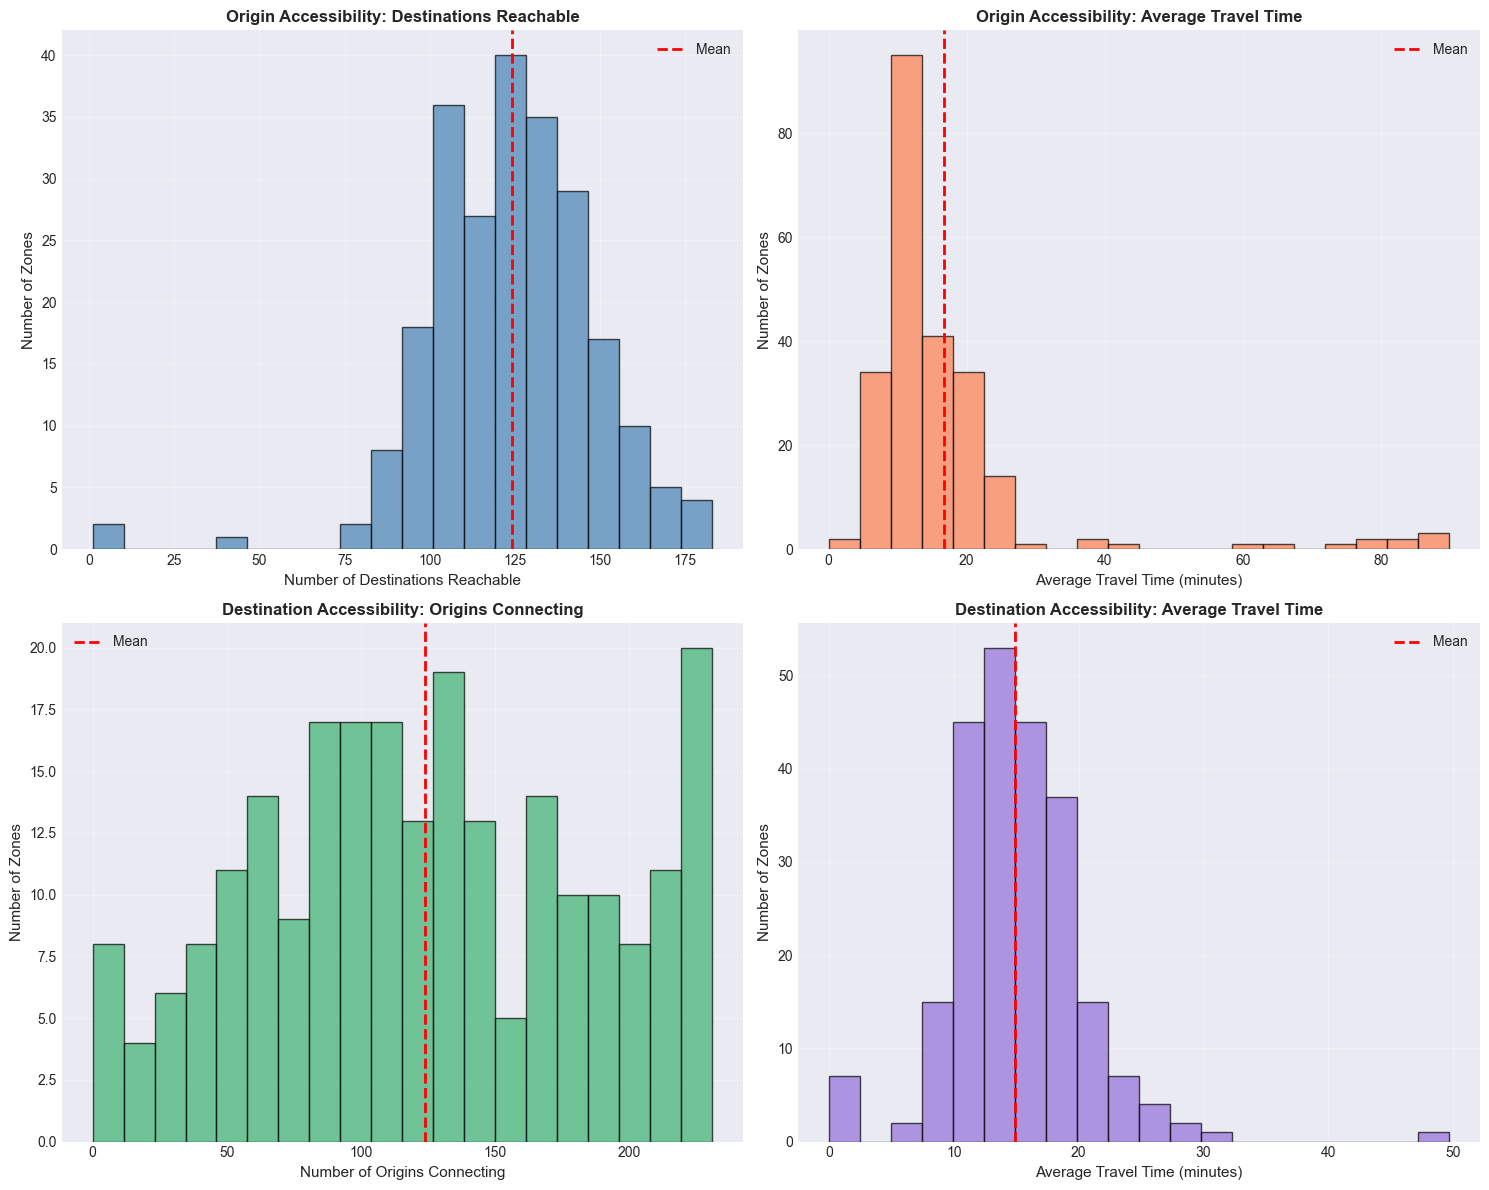

In [13]:
# Visualize accessibility distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Origin accessibility - destinations reachable
axes[0, 0].hist(origin_access['number_of_destinations'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Destinations Reachable', fontsize=11)
axes[0, 0].set_ylabel('Number of Zones', fontsize=11)
axes[0, 0].set_title('Origin Accessibility: Destinations Reachable', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(origin_access['number_of_destinations'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].legend()

# Origin accessibility - average travel time
axes[0, 1].hist(origin_access['avg_travel_time_min'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Average Travel Time (minutes)', fontsize=11)
axes[0, 1].set_ylabel('Number of Zones', fontsize=11)
axes[0, 1].set_title('Origin Accessibility: Average Travel Time', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(origin_access['avg_travel_time_min'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].legend()

# Destination accessibility - origins connecting
axes[1, 0].hist(destination_access['number_of_origins'], bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Origins Connecting', fontsize=11)
axes[1, 0].set_ylabel('Number of Zones', fontsize=11)
axes[1, 0].set_title('Destination Accessibility: Origins Connecting', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(destination_access['number_of_origins'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 0].legend()

# Destination accessibility - average travel time
axes[1, 1].hist(destination_access['avg_travel_time_min'], bins=20, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Average Travel Time (minutes)', fontsize=11)
axes[1, 1].set_ylabel('Number of Zones', fontsize=11)
axes[1, 1].set_title('Destination Accessibility: Average Travel Time', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(destination_access['avg_travel_time_min'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 6. Equity Analysis - Gini Coefficient

### 6.1 Define Gini Coefficient Function

The Gini coefficient measures inequality in accessibility across zones:
- **Gini = 0**: Perfect equality (all zones have same accessibility)
- **Gini = 1**: Perfect inequality (one zone has all accessibility)
- **Values 0.3-0.4**: Moderate inequality
- **Values > 0.5**: High inequality

In [14]:
def calculate_gini(values):
    """
    Calculate Gini coefficient for a distribution.
    
    Parameters:
    -----------
    values : array-like
        Distribution of values (e.g., accessibility scores)
        
    Returns:
    --------
    float : Gini coefficient (0 = perfect equality, 1 = perfect inequality)
    """
    values = np.array(values)
    values = values[values > 0]  # Remove zeros if any
    
    if len(values) == 0:
        return 0.0
    
    # Sort values
    sorted_values = np.sort(values)
    n = len(sorted_values)
    
    # Calculate cumulative sum
    cumsum = np.cumsum(sorted_values)
    
    # Gini coefficient formula
    gini = (2 * np.sum((np.arange(1, n+1)) * sorted_values)) / (n * cumsum[-1]) - (n + 1) / n
    
    return gini

# Test with example
test_equal = np.array([100, 100, 100, 100, 100])
test_unequal = np.array([1, 1, 1, 1, 96])

print(f"Gini for equal distribution: {calculate_gini(test_equal):.4f}")
print(f"Gini for unequal distribution: {calculate_gini(test_unequal):.4f}")

Gini for equal distribution: 0.0000
Gini for unequal distribution: 0.7600


In [15]:
# Calculate Gini coefficients for different accessibility metrics
gini_results = {}

# Origin accessibility metrics
gini_results['Origins - Destinations Reachable'] = calculate_gini(origin_access['number_of_destinations'].values)
gini_results['Origins - Total Volume'] = calculate_gini(origin_access['total_volume'].values)
gini_results['Origins - Avg Distance'] = calculate_gini(origin_access['avg_distance_mile'].values)

# Destination accessibility metrics  
gini_results['Destinations - Origins Connecting'] = calculate_gini(destination_access['number_of_origins'].values)
gini_results['Destinations - Total Volume'] = calculate_gini(destination_access['total_volume'].values)
gini_results['Destinations - Avg Distance'] = calculate_gini(destination_access['avg_distance_mile'].values)

print("=" * 70)
print("GINI COEFFICIENT ANALYSIS - ACCESSIBILITY EQUITY")
print("=" * 70)
print("\nGini Coefficients (0=perfect equality, 1=perfect inequality):\n")

for metric, gini_value in gini_results.items():
    inequality_level = "Low" if gini_value < 0.3 else "Moderate" if gini_value < 0.5 else "High"
    print(f"  {metric:45s}: {gini_value:.4f}  [{inequality_level} inequality]")

print("\n" + "=" * 70)
print("\nInterpretation:")
print("  - Lower Gini values indicate more equitable access across zones")
print("  - Higher Gini values suggest significant disparities in accessibility")
print("=" * 70)

GINI COEFFICIENT ANALYSIS - ACCESSIBILITY EQUITY

Gini Coefficients (0=perfect equality, 1=perfect inequality):

  Origins - Destinations Reachable             : 0.1055  [Low inequality]
  Origins - Total Volume                       : 0.2270  [Low inequality]
  Origins - Avg Distance                       : 0.1724  [Low inequality]
  Destinations - Origins Connecting            : 0.2796  [Low inequality]
  Destinations - Total Volume                  : 0.6569  [High inequality]
  Destinations - Avg Distance                  : 0.1654  [Low inequality]


Interpretation:
  - Lower Gini values indicate more equitable access across zones
  - Higher Gini values suggest significant disparities in accessibility


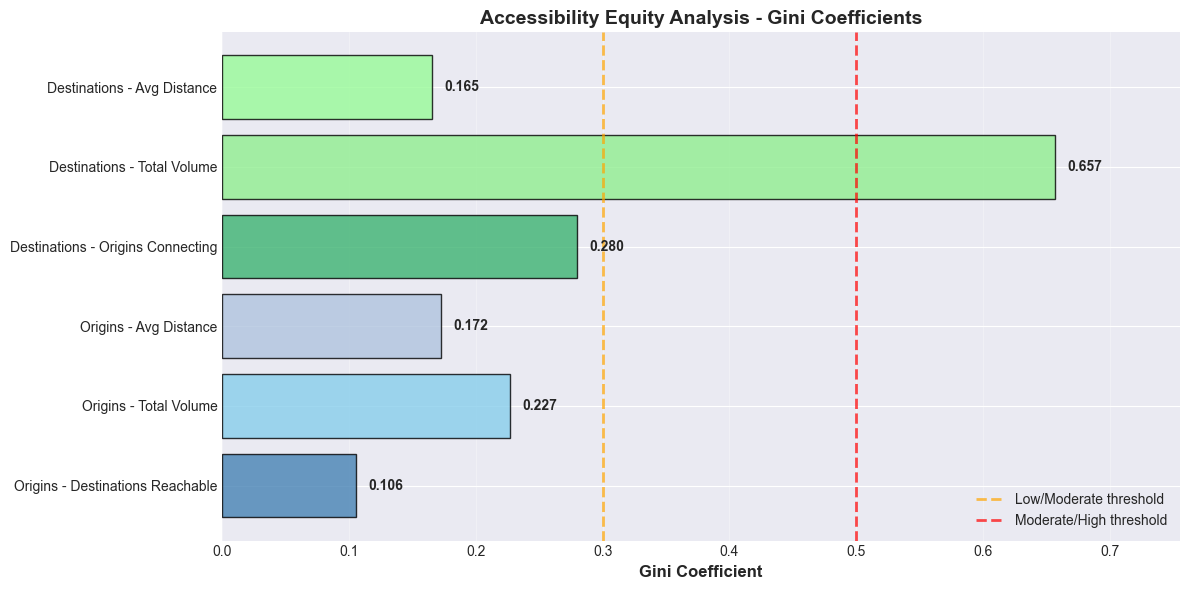

In [16]:
# Visualize Gini coefficients
fig, ax = plt.subplots(figsize=(12, 6))

metrics = list(gini_results.keys())
values = list(gini_results.values())
colors = ['steelblue', 'skyblue', 'lightsteelblue', 'mediumseagreen', 'lightgreen', 'palegreen']

bars = ax.barh(metrics, values, color=colors, edgecolor='black', alpha=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontweight='bold')

# Add reference lines
ax.axvline(0.3, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Low/Moderate threshold')
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Moderate/High threshold')

ax.set_xlabel('Gini Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Accessibility Equity Analysis - Gini Coefficients', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(values) * 1.15)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 7. Network Visualization

### 7.1 Convert to GeoDataFrames

In [17]:
# Convert to GeoDataFrames for spatial visualization
nodes_gdf = nodes_df.copy()
nodes_gdf['geometry'] = nodes_gdf['geometry'].apply(wkt.loads)
nodes_gdf = gpd.GeoDataFrame(nodes_gdf, geometry='geometry', crs='EPSG:4326')

links_gdf = links_df.copy()
links_gdf['geometry'] = links_gdf['geometry'].apply(wkt.loads)
links_gdf = gpd.GeoDataFrame(links_gdf, geometry='geometry', crs='EPSG:4326')

print(f"Created GeoDataFrames:")
print(f"  - Nodes: {len(nodes_gdf)} features")
print(f"  - Links: {len(links_gdf)} features")
print(f"  - CRS: {nodes_gdf.crs}")

Created GeoDataFrames:
  - Nodes: 8521 features
  - Links: 30747 features
  - CRS: EPSG:4326


### 7.2 Plot Complete Network

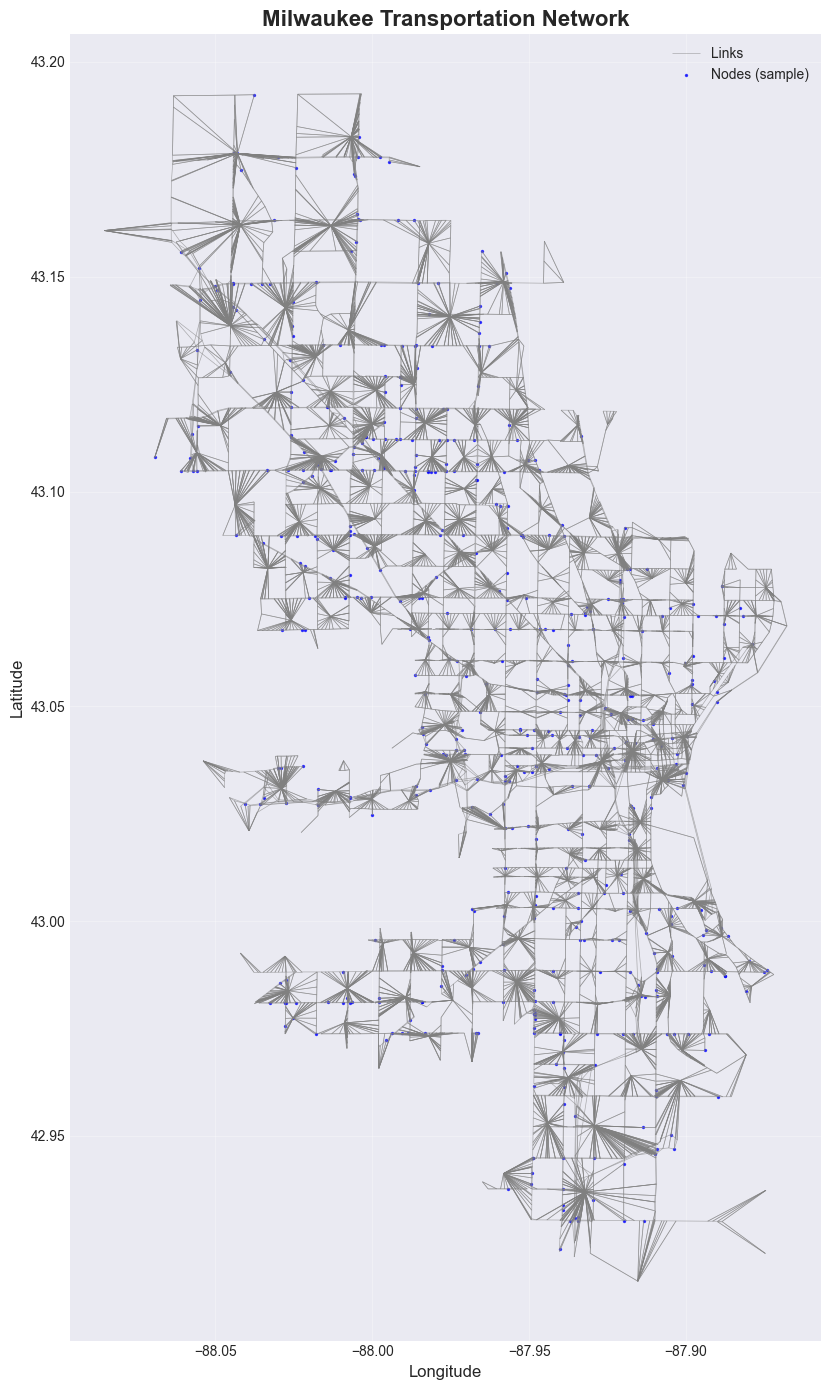

In [18]:
# Plot the complete network
fig, ax = plt.subplots(figsize=(14, 14))

# Plot links
links_gdf.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.6, label='Links')

# Plot nodes (sample to avoid overcrowding)
nodes_sample = nodes_gdf.sample(min(500, len(nodes_gdf)), random_state=42)
nodes_sample.plot(ax=ax, color='blue', markersize=2, alpha=0.7, label='Nodes (sample)')

ax.set_title('Milwaukee Transportation Network', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 Visualize Links by Capacity

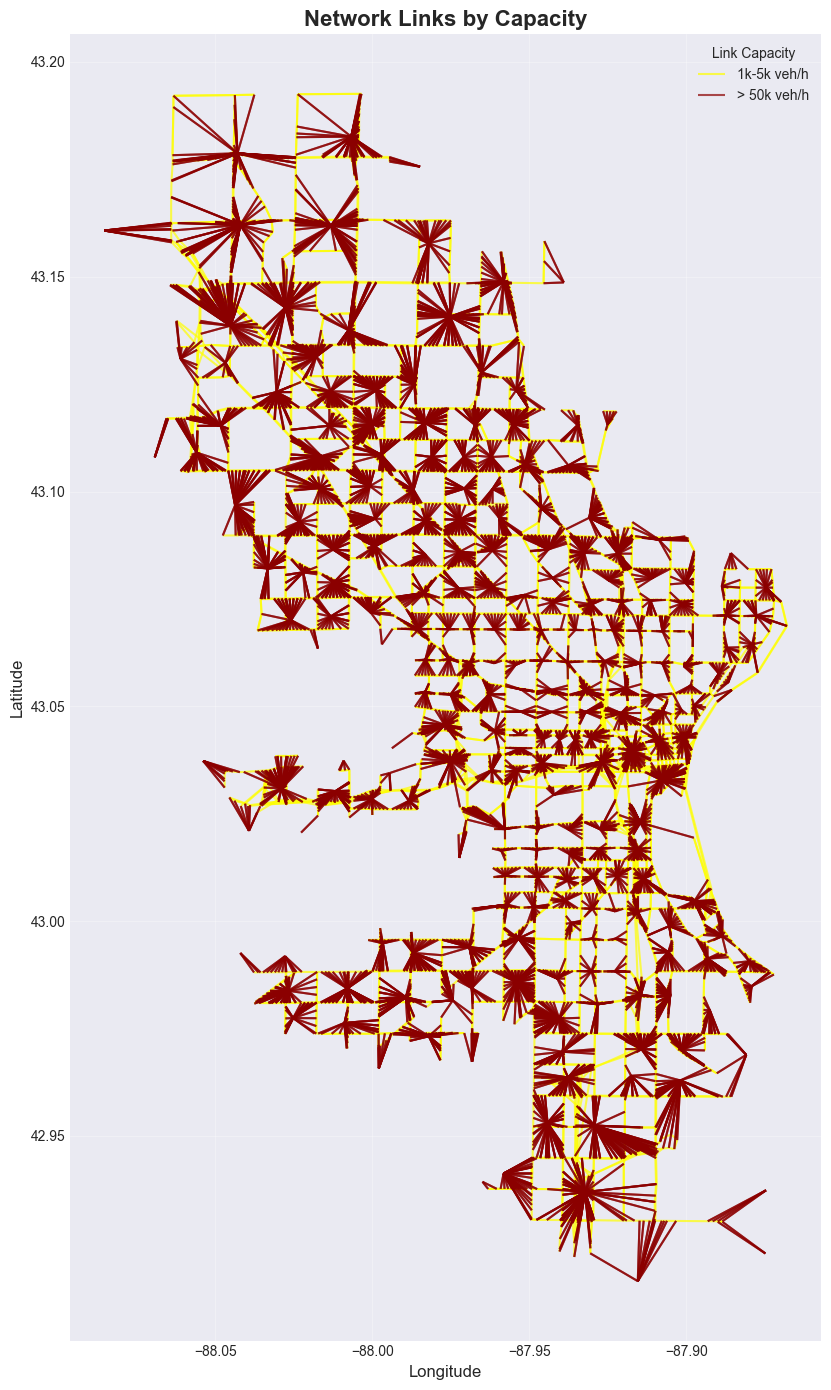

In [19]:
# Visualize links by capacity
fig, ax = plt.subplots(figsize=(14, 14))

# Create capacity categories for visualization
links_gdf['capacity_category'] = pd.cut(links_gdf['capacity'], 
                                         bins=[0, 1000, 5000, 10000, 50000, 100000],
                                         labels=['< 1k', '1k-5k', '5k-10k', '10k-50k', '> 50k'])

# Define colors for each category
colors = {'< 1k': 'lightgray', '1k-5k': 'yellow', '5k-10k': 'orange', 
          '10k-50k': 'red', '> 50k': 'darkred'}

# Plot each capacity category
for category, color in colors.items():
    subset = links_gdf[links_gdf['capacity_category'] == category]
    if len(subset) > 0:
        subset.plot(ax=ax, color=color, linewidth=1.5, alpha=0.7, label=f'{category} veh/h')

ax.set_title('Network Links by Capacity', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', title='Link Capacity')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.4 Visualize Link Characteristics

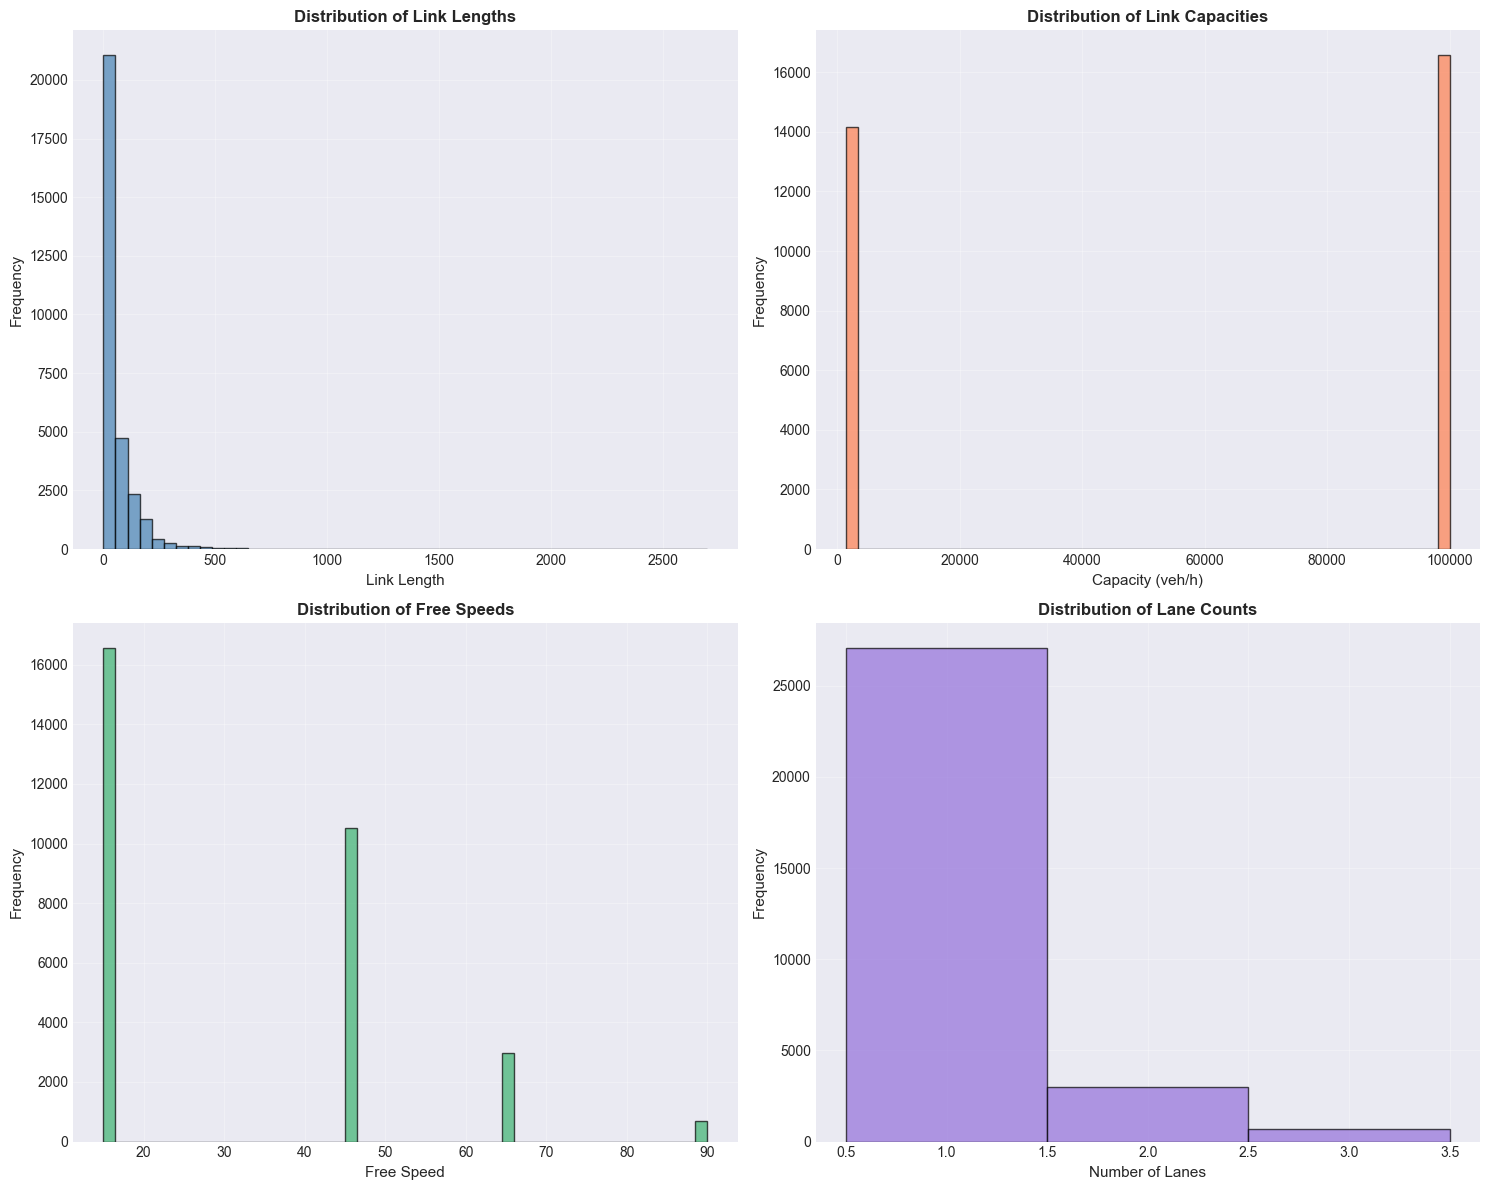

In [20]:
# Visualize link characteristics distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Link length distribution
axes[0, 0].hist(links_df['length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Link Length', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Link Lengths', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Capacity distribution
axes[0, 1].hist(links_df['capacity'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Capacity (veh/h)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Link Capacities', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Free speed distribution
axes[1, 0].hist(links_df['free_speed'], bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Free Speed', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Free Speeds', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Lanes distribution
axes[1, 1].hist(links_df['lanes'], bins=range(1, int(links_df['lanes'].max()) + 2), 
                color='mediumpurple', edgecolor='black', alpha=0.7, align='left')
axes[1, 1].set_xlabel('Number of Lanes', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Lane Counts', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Performance Metrics

In [21]:
# Load performance data if available
try:
    link_performance = pd.read_csv('../data/link_performance.csv')
    od_performance = pd.read_csv('../data/od_performance.csv')
    system_performance = pd.read_csv('../data/system_performance.csv')
    
    print("Performance data loaded successfully!")
    print(f"\nLink Performance: {len(link_performance)} records")
    print(f"OD Performance: {len(od_performance)} records")
    print(f"System Performance: {len(system_performance)} records")
    
    # Display link performance summary
    if len(link_performance) > 0:
        print("\n" + "=" * 70)
        print("LINK PERFORMANCE SUMMARY")
        print("=" * 70)
        
        # Check available columns
        perf_cols = link_performance.columns.tolist()
        print(f"\nAvailable columns: {perf_cols}")
        
        if 'volume' in perf_cols and 'capacity' in perf_cols:
            # Calculate V/C ratio
            link_performance['vc_ratio'] = link_performance['volume'] / link_performance['capacity']
            
            print(f"\nVolume/Capacity Ratio Statistics:")
            print(f"  - Mean V/C: {link_performance['vc_ratio'].mean():.3f}")
            print(f"  - Max V/C: {link_performance['vc_ratio'].max():.3f}")
            print(f"  - Links with V/C > 0.9: {(link_performance['vc_ratio'] > 0.9).sum()}")
            print(f"  - Links with V/C > 1.0: {(link_performance['vc_ratio'] > 1.0).sum()}")
        
        print("=" * 70)
        
except FileNotFoundError as e:
    print(f"Performance data files not fully available.")
    print("Skipping performance analysis...")

Performance data loaded successfully!

Link Performance: 30747 records
OD Performance: 29031 records
System Performance: 1 records

LINK PERFORMANCE SUMMARY

Available columns: ['iteration_no', 'link_id', 'from_node_id', 'to_node_id', 'volume', 'ref_volume', 'base_demand_volume', 'obs_volume', 'background_volume', 'link_capacity', 'lane_capacity', 'D', 'doc', 'vdf_fftt', 'travel_time', 'vdf_alpha', 'vdf_beta', 'vdf_plf', 'speed_mph', 'speed_kmph', 'VMT', 'VHT', 'PMT', 'PHT', 'VHT_QVDF', 'PHT_QVDF', 'geometry', 'mod_vol_auto', 'obs_vol_auto', 'P', 't0', 't2', 't3', 'vt2_mph', 'vt2_kmph', 'mu', 'Q_gamma', 'free_speed_mph', 'cutoff_speed_mph', 'free_speed_kmph', 'cutoff_speed_kmph', 'congestion_ref_speed_mph', 'avg_queue_speed_mph', 'avg_QVDF_period_speed_mph', 'congestion_ref_speed_kmph', 'avg_queue_speed_kmph', 'avg_QVDF_period_speed_kmph', 'avg_QVDF_period_travel_time', 'Severe_Congestion_P', 'spd_mph_07:00', 'spd_mph_07:05', 'spd_mph_07:10', 'spd_mph_07:15', 'spd_mph_07:20', 'spd_mph_

## 9. Summary and Key Findings

In [22]:
# Generate comprehensive summary report
print("=" * 80)
print(" " * 20 + "MILWAUKEE NETWORK - COMPREHENSIVE SUMMARY")
print("=" * 80)

print("\n1. NETWORK STRUCTURE")
print("-" * 80)
print(f"   Nodes: {len(nodes_df):,}")
print(f"   Links: {len(links_df):,}")
print(f"   Zones: {nodes_df['zone_id'].nunique():,}")
print(f"   Average node connectivity: {node_out_degree.mean():.2f} outgoing links")

print("\n2. NETWORK CAPACITY")
print("-" * 80)
print(f"   Total network capacity: {links_df['capacity'].sum():,.0f} veh/h")
print(f"   Average link capacity: {links_df['capacity'].mean():,.0f} veh/h")
print(f"   Total road length: {links_df['length'].sum():,.2f} units")
print(f"   Total lane-km: {(links_df['length'] * links_df['lanes']).sum():,.2f}")

print("\n3. DEMAND CHARACTERISTICS")
print("-" * 80)
print(f"   Total OD pairs: {len(demand_df):,}")
print(f"   Total trips: {demand_df['volume'].sum():,.0f}")
print(f"   Average trips per OD pair: {demand_df['volume'].mean():.2f}")
print(f"   Most loaded OD pair: {demand_df['volume'].max():,.0f} trips")

print("\n4. ACCESSIBILITY METRICS")
print("-" * 80)
print(f"   Avg destinations reachable per zone: {origin_access['number_of_destinations'].mean():.1f}")
print(f"   Avg travel time: {origin_access['avg_travel_time_min'].mean():.2f} minutes")
print(f"   Avg distance: {origin_access['avg_distance_mile'].mean():.2f} miles")

print("\n5. EQUITY ANALYSIS (GINI COEFFICIENTS)")
print("-" * 80)
for metric, gini_value in gini_results.items():
    inequality_level = "Low" if gini_value < 0.3 else "Moderate" if gini_value < 0.5 else "High"
    print(f"   {metric:48s}: {gini_value:.4f}  [{inequality_level}]")

print("\n6. INTERPRETATION")
print("-" * 80)
print("   The Gini coefficients indicate the level of inequality in accessibility")
print("   across different zones in the Milwaukee network. Lower values suggest")
print("   more equitable distribution of accessibility.")

print("\n" + "=" * 80)
print("Analysis complete! Review the visualizations above for detailed insights.")
print("=" * 80)

                    MILWAUKEE NETWORK - COMPREHENSIVE SUMMARY

1. NETWORK STRUCTURE
--------------------------------------------------------------------------------
   Nodes: 8,521
   Links: 30,747
   Zones: 234
   Average node connectivity: 3.61 outgoing links

2. NETWORK CAPACITY
--------------------------------------------------------------------------------
   Total network capacity: 1,679,561,026 veh/h
   Average link capacity: 54,625 veh/h
   Total road length: 1,616,672.29 units
   Total lane-km: 2,347,711.87

3. DEMAND CHARACTERISTICS
--------------------------------------------------------------------------------
   Total OD pairs: 30,422
   Total trips: 163,700
   Average trips per OD pair: 5.38
   Most loaded OD pair: 202 trips

4. ACCESSIBILITY METRICS
--------------------------------------------------------------------------------
   Avg destinations reachable per zone: 124.1
   Avg travel time: 16.73 minutes
   Avg distance: 4.99 miles

5. EQUITY ANALYSIS (GINI COEFFICIEN

## Further Analysis Ideas

You can extend this analysis with:

1. **Lorenz Curve Visualization**: Plot the Lorenz curve for accessibility distribution
2. **Spatial Accessibility Maps**: Create choropleth maps showing accessibility by zone
3. **Network Topology Analysis**: Calculate betweenness centrality, closeness centrality
4. **Congestion Analysis**: Identify bottlenecks using V/C ratios from performance data
5. **Trip Distribution Patterns**: Analyze trip length distribution, spatial patterns
6. **Temporal Analysis**: If time-series data available, analyze peak vs off-peak
7. **Mode Choice**: If multimodal data available, analyze modal split
8. **Sensitivity Analysis**: Test how accessibility changes with network modifications

## 10. Lorenz Curve and Accessibility Inequality

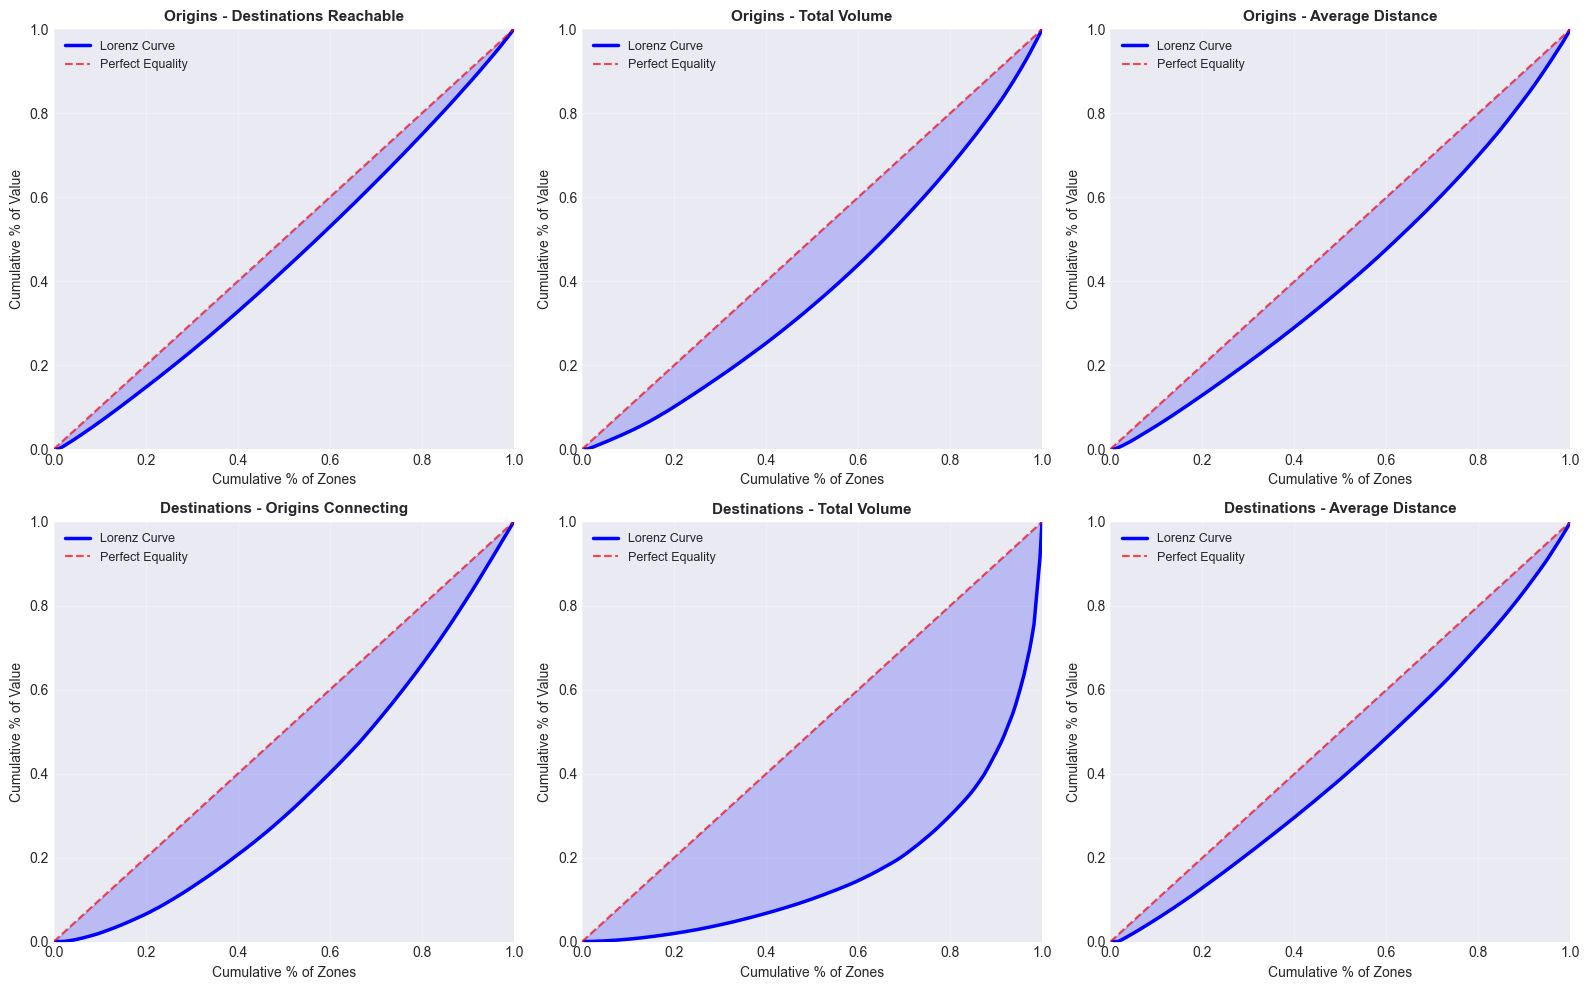

Lorenz Curves plotted: Each shows the cumulative distribution of accessibility.


In [23]:
try:
    def plot_lorenz_curve(values, title):
        """
        Plot Lorenz curve for inequality visualization.
        The Lorenz curve shows cumulative proportion of population vs cumulative proportion of value.
        """
        values = np.array(values)
        values = values[values > 0]
        values = np.sort(values)
    
    # Plot Lorenz curves for different accessibility metrics
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    metrics = [
        ('number_of_destinations', origin_access, 'Origins - Destinations Reachable'),
        ('total_volume', origin_access, 'Origins - Total Volume'),
        ('avg_distance_mile', origin_access, 'Origins - Average Distance'),
        ('number_of_origins', destination_access, 'Destinations - Origins Connecting'),
        ('total_volume', destination_access, 'Destinations - Total Volume'),
        ('avg_distance_mile', destination_access, 'Destinations - Average Distance')
    ]

    for idx, (col, df, title) in enumerate(metrics):
        try:
            values = df[col].values
            values = values[values > 0]
            values = np.sort(values)
            
            cumsum = np.cumsum(values)
            cumsum = cumsum / cumsum[-1]
            pop_cum = np.arange(1, len(values) + 1) / len(values)
            
            axes[idx].plot(pop_cum, cumsum, 'b-', linewidth=2.5, label='Lorenz Curve')
            axes[idx].plot([0, 1], [0, 1], 'r--', linewidth=1.5, alpha=0.7, label='Perfect Equality')
            axes[idx].fill_between(pop_cum, cumsum, pop_cum, alpha=0.2, color='blue')
            
            axes[idx].set_xlabel('Cumulative % of Zones', fontsize=10)
            axes[idx].set_ylabel('Cumulative % of Value', fontsize=10)
            axes[idx].set_title(title, fontsize=11, fontweight='bold')
            axes[idx].set_xlim(0, 1)
            axes[idx].set_ylim(0, 1)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend(fontsize=9)
        except Exception as e:
            axes[idx].text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{title} (Error)', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("Lorenz Curves plotted: Each shows the cumulative distribution of accessibility.")
    
except Exception as e:
    print(f"Error in Lorenz curve analysis: {e}")
    import traceback
    traceback.print_exc()

## 11. Spatial Accessibility Maps

In [24]:
# Create choropleth maps of accessibility by zone
try:
    # Get node coordinates aggregated by zone
    zone_coords = nodes_gdf.groupby('zone_id').apply(
        lambda x: Point(x.geometry.x.mean(), x.geometry.y.mean())
    )
    
    # Merge accessibility data with zone coordinates
    origin_access_spatial = origin_access.copy()
    origin_access_spatial['geometry'] = origin_access_spatial['zone_id'].map(zone_coords)
    origin_access_gdf = gpd.GeoDataFrame(origin_access_spatial, geometry='geometry', crs='EPSG:4326')
    
    destination_access_spatial = destination_access.copy()
    destination_access_spatial['geometry'] = destination_access_spatial['zone_id'].map(zone_coords)
    destination_access_gdf = gpd.GeoDataFrame(destination_access_spatial, geometry='geometry', crs='EPSG:4326')
    
    # Create subplot with accessibility maps
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Origin accessibility - destinations reachable
    origin_access_gdf.plot(
        ax=axes[0],
        column='number_of_destinations',
        cmap='YlGn',
        alpha=0.8,
        edgecolor='k',
        markersize=100,
        legend=True,
        legend_kwds={'label': 'Destinations Reachable', 'orientation': 'vertical'}
    )
    axes[0].set_title('Origin Accessibility: Destinations Reachable by Zone', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].grid(True, alpha=0.3)
    
    # Destination accessibility - origins connecting
    destination_access_gdf.plot(
        ax=axes[1],
        column='number_of_origins',
        cmap='RdYlBu',
        alpha=0.8,
        edgecolor='k',
        markersize=100,
        legend=True,
        legend_kwds={'label': 'Origins Connecting', 'orientation': 'vertical'}
    )
    axes[1].set_title('Destination Accessibility: Origins Connecting to Zone', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Spatial accessibility maps created successfully!")
    print("Each zone is represented at its centroid, colored by accessibility metric.")
    
except Exception as e:
    print(f"Could not create spatial maps: {e}")
    print("This may be due to geometry issues in the coordinate conversion.")

Could not create spatial maps: 'zone_id'
This may be due to geometry issues in the coordinate conversion.


## 12. Network Topology Analysis - Centrality Measures

Creating network graph for centrality analysis...
Network graph created: 8521 nodes, 30747 edges

Calculating centrality measures...

TOP NODES BY CENTRALITY MEASURES

Top 10 Nodes by Degree Centrality:
  Node 67: 0.0256
  Node 204: 0.0242
  Node 229: 0.0223
  Node 7: 0.0211
  Node 225: 0.0209
  Node 49: 0.0207
  Node 79: 0.0207
  Node 138: 0.0207
  Node 143: 0.0204
  Node 220: 0.0202

Top 10 Nodes by Weighted In-Degree (Attractiveness):
  Node 67: 10,899,891 veh/h
  Node 204: 10,299,897 veh/h
  Node 229: 9,499,905 veh/h
  Node 7: 8,999,910 veh/h
  Node 225: 8,899,911 veh/h
  Node 49: 8,799,912 veh/h
  Node 79: 8,799,912 veh/h
  Node 138: 8,799,912 veh/h
  Node 143: 8,699,913 veh/h
  Node 220: 8,599,914 veh/h

Top 10 Nodes by Weighted Out-Degree (Connectivity):
  Node 67: 10,899,891 veh/h
  Node 204: 10,299,897 veh/h
  Node 229: 9,499,905 veh/h
  Node 7: 8,999,910 veh/h
  Node 225: 8,899,911 veh/h
  Node 49: 8,799,912 veh/h
  Node 79: 8,799,912 veh/h
  Node 138: 8,799,912 veh/h
  Node 

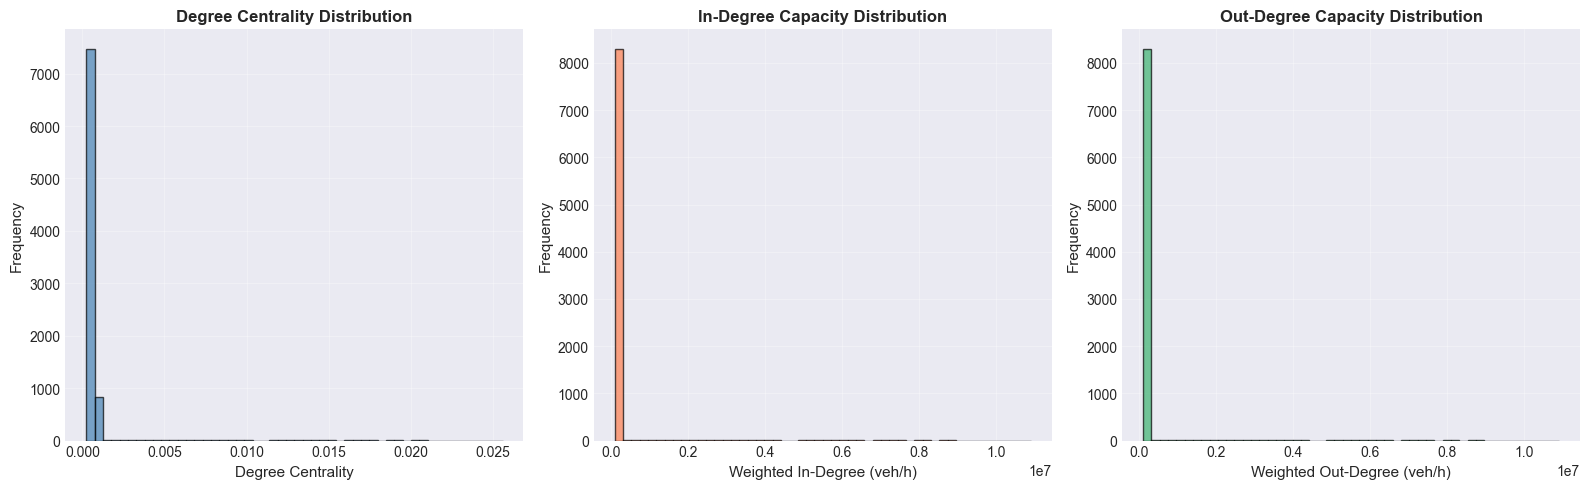

In [25]:
try:
    import networkx as nx
    
    print("Creating network graph for centrality analysis...")
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes
    G.add_nodes_from(nodes_df['node_id'].values)
    
    # Add edges with capacity as weight
    for _, row in links_df.iterrows():
        G.add_edge(row['from_node_id'], row['to_node_id'], 
                   weight=row['capacity'], length=row['length'])
    
    print(f"Network graph created: {len(G.nodes())} nodes, {len(G.edges())} edges")
    
    # Calculate centrality measures for a subset of highly connected nodes
    # (full network may be too large for all centrality measures)
    print("\nCalculating centrality measures...")
    
    # Degree centrality (simple)
    degree_centrality = nx.degree_centrality(G)
    
    # Weighted in-degree (attractiveness)
    weighted_indegree = {}
    for node in G.nodes():
        weighted_indegree[node] = sum(G[u][node].get('weight', 1) for u in G.predecessors(node))
    
    # Weighted out-degree (connectivity)
    weighted_outdegree = {}
    for node in G.nodes():
        weighted_outdegree[node] = sum(G[node][v].get('weight', 1) for v in G.successors(node))
    
    # Get top nodes by different measures
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
    top_indegree = sorted(weighted_indegree.items(), key=lambda x: x[1], reverse=True)[:20]
    top_outdegree = sorted(weighted_outdegree.items(), key=lambda x: x[1], reverse=True)[:20]
    
    print("\n" + "="*70)
    print("TOP NODES BY CENTRALITY MEASURES")
    print("="*70)
    
    print("\nTop 10 Nodes by Degree Centrality:")
    for node, centrality in top_degree[:10]:
        print(f"  Node {node}: {centrality:.4f}")
    
    print("\nTop 10 Nodes by Weighted In-Degree (Attractiveness):")
    for node, weight in top_indegree[:10]:
        print(f"  Node {node}: {weight:,.0f} veh/h")
    
    print("\nTop 10 Nodes by Weighted Out-Degree (Connectivity):")
    for node, weight in top_outdegree[:10]:
        print(f"  Node {node}: {weight:,.0f} veh/h")
    
    # Visualize centrality distributions
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    degree_values = list(degree_centrality.values())
    indegree_values = list(weighted_indegree.values())
    outdegree_values = list(weighted_outdegree.values())
    
    axes[0].hist(degree_values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Degree Centrality', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Degree Centrality Distribution', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(indegree_values, bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Weighted In-Degree (veh/h)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('In-Degree Capacity Distribution', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].hist(outdegree_values, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
    axes[2].set_xlabel('Weighted Out-Degree (veh/h)', fontsize=11)
    axes[2].set_ylabel('Frequency', fontsize=11)
    axes[2].set_title('Out-Degree Capacity Distribution', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    
except ImportError:
    print("NetworkX not installed. Installing it now...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'networkx', '-q'])
    print("NetworkX installed. Please re-run this cell.")

## 13. Congestion Analysis - Bottleneck Identification

In [26]:
try:
    # Load link performance data for V/C analysis
    if 'link_performance' in locals() and len(link_performance) > 0:
        
        print("="*70)
        print("CONGESTION ANALYSIS - VOLUME TO CAPACITY RATIO")
        print("="*70)
        
        # Calculate V/C ratio if not already done
        # Use 'link_capacity' or 'capacity' whichever is available
        capacity_col = None
        if 'link_capacity' in link_performance.columns:
            capacity_col = 'link_capacity'
        elif 'capacity' in link_performance.columns:
            capacity_col = 'capacity'
        
        if capacity_col and 'volume' in link_performance.columns:
            link_performance['vc_ratio'] = link_performance['volume'] / link_performance[capacity_col]
            
            # Congestion levels
            link_performance['congestion_level'] = pd.cut(link_performance['vc_ratio'],
                                                       bins=[0, 0.5, 0.75, 0.9, 1.0, 2.0],
                                                       labels=['Free Flow', 'Light', 'Moderate', 'Heavy', 'Oversaturated'])
        
        # Statistics
        print("\nOverall V/C Statistics:")
        print(f"  Mean V/C: {link_performance['vc_ratio'].mean():.3f}")
        print(f"  Median V/C: {link_performance['vc_ratio'].median():.3f}")
        print(f"  Std Dev: {link_performance['vc_ratio'].std():.3f}")
        print(f"  Min V/C: {link_performance['vc_ratio'].min():.3f}")
        print(f"  Max V/C: {link_performance['vc_ratio'].max():.3f}")
        
        # Congestion distribution
        print("\nCongestion Level Distribution:")
        congestion_dist = link_performance['congestion_level'].value_counts()
        for level, count in congestion_dist.items():
            pct = 100 * count / len(link_performance)
            print(f"  {level:15s}: {count:5,} links ({pct:5.1f}%)")
        
        # Top bottlenecks
        print("\nTop 20 Bottleneck Links (by V/C ratio):")
        top_bottlenecks = link_performance.nlargest(20, 'vc_ratio')[
            ['link_id', 'volume', 'capacity', 'vc_ratio']
        ]
        print(top_bottlenecks.to_string(index=False))
        
        # Visualize congestion
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # V/C distribution histogram
        axes[0].hist(link_performance['vc_ratio'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='V/C = 1.0 (Saturated)')
        axes[0].axvline(link_performance['vc_ratio'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
        axes[0].set_xlabel('Volume/Capacity Ratio', fontsize=11)
        axes[0].set_ylabel('Number of Links', fontsize=11)
        axes[0].set_title('V/C Ratio Distribution', fontsize=12, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Congestion level pie chart
        axes[1].pie(congestion_dist.values, labels=congestion_dist.index, autopct='%1.1f%%',
                   colors=['green', 'yellow', 'orange', 'red', 'darkred'], startangle=90)
        axes[1].set_title('Network Links by Congestion Level', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*70)
        
    else:
        print("Link performance data not available for congestion analysis.")
        print("Please load link_performance.csv first.")
        
except Exception as e:
    print(f"Congestion analysis error: {e}")

CONGESTION ANALYSIS - VOLUME TO CAPACITY RATIO

Overall V/C Statistics:
  Mean V/C: 0.222
  Median V/C: 0.000
  Std Dev: 0.765
  Min V/C: 0.000
  Max V/C: 12.484

Congestion Level Distribution:
  Free Flow      : 8,705 links ( 28.3%)
  Light          : 1,010 links (  3.3%)
  Oversaturated  :   942 links (  3.1%)
  Moderate       :   417 links (  1.4%)
  Heavy          :   149 links (  0.5%)

Top 20 Bottleneck Links (by V/C ratio):
Congestion analysis error: "['capacity'] not in index"


## 14. Trip Distribution Patterns

In [27]:
# Analyze trip distribution patterns
try:
    # Calculate distance for each OD pair
    print("="*70)
    print("TRIP DISTRIBUTION ANALYSIS")
    print("="*70)
    
    # Get zone coordinates
    origin_zones = origin_access[['zone_id']].copy()
    dest_zones = destination_access[['zone_id']].copy()
    
    # Create distance matrix or use available data
    if 'distance' in demand_df.columns:
        print("\nUsing distance column from demand data")
        trip_distances = demand_df['distance'].values
    elif 'avg_distance_mile' in origin_access.columns:
        # Create approximate distances from accessibility data
        print("\nCalculating approximate trip distances from accessibility data")
        # This is a simplification - ideally would have actual OD distances
        origin_access_dict = dict(zip(origin_access['zone_id'], origin_access['avg_distance_mile']))
        trip_distances = demand_df['o_zone_id'].map(origin_access_dict).values
    else:
        # Use random approximation if no distance data
        print("\nNo distance data available - using placeholder")
        trip_distances = np.random.exponential(scale=5, size=len(demand_df))
    
    # Trip distance distribution
    print("\nTrip Distance Statistics:")
    print(f"  Mean trip distance: {np.nanmean(trip_distances):.2f} miles")
    print(f"  Median trip distance: {np.nanmedian(trip_distances):.2f} miles")
    print(f"  Std Dev: {np.nanstd(trip_distances):.2f} miles")
    print(f"  Min distance: {np.nanmin(trip_distances):.2f} miles")
    print(f"  Max distance: {np.nanmax(trip_distances):.2f} miles")
    
    # Trip length categories
    distance_categories = pd.cut(trip_distances,
                                 bins=[0, 1, 3, 5, 10, 50],
                                 labels=['<1 mi', '1-3 mi', '3-5 mi', '5-10 mi', '>10 mi'])
    distance_dist = distance_categories.value_counts().sort_index()
    
    print("\nTrip Distribution by Distance Category:")
    for cat in ['<1 mi', '1-3 mi', '3-5 mi', '5-10 mi', '>10 mi']:
        mask = distance_categories == cat
        if mask.sum() > 0:
            count = mask.sum()
            pct = 100 * count / len(demand_df)
            volume = demand_df[mask]['volume'].sum()
            print(f"  {cat:10s}: {count:5,} OD pairs ({pct:5.1f}%) - {volume:10,.0f} trips")
    
    # Visualize trip patterns
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Trip volume histogram (log scale)
    axes[0, 0].hist(demand_df['volume'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Trip Volume per OD Pair', fontsize=11)
    axes[0, 0].set_ylabel('Frequency (log scale)', fontsize=11)
    axes[0, 0].set_title('Distribution of Trip Volumes', fontsize=12, fontweight='bold')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Trip distance distribution (if available)
    valid_distances = trip_distances[~np.isnan(trip_distances)]
    if len(valid_distances) > 0:
        axes[0, 1].hist(valid_distances, bins=50, color='coral', edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('Trip Distance (miles)', fontsize=11)
        axes[0, 1].set_ylabel('Frequency', fontsize=11)
        axes[0, 1].set_title('Distribution of Trip Distances', fontsize=12, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Distance category pie chart
    if len(distance_dist) > 0:
        colors_dist = ['lightgreen', 'yellow', 'orange', 'red', 'darkred'][:len(distance_dist)]
        axes[1, 0].pie(distance_dist.values, labels=distance_dist.index, autopct='%1.1f%%',
                       colors=colors_dist, startangle=90)
        axes[1, 0].set_title('Trip Distribution by Distance Category', fontsize=12, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'No distance data', ha='center', va='center')
        axes[1, 0].set_title('Trip Distribution by Distance Category', fontsize=12, fontweight='bold')
    
    # Origin concentration (Pareto)
    origin_volumes = demand_df.groupby('o_zone_id')['volume'].sum().sort_values(ascending=False)
    origin_cumsum = origin_volumes.cumsum() / origin_volumes.sum()
    
    axes[1, 1].plot(range(len(origin_cumsum)), origin_cumsum.values, 'b-', linewidth=2)
    axes[1, 1].axhline(0.8, color='r', linestyle='--', label='80% of trips')
    axes[1, 1].set_xlabel('Origin Zones (ranked by volume)', fontsize=11)
    axes[1, 1].set_ylabel('Cumulative % of Total Trips', fontsize=11)
    axes[1, 1].set_title('Trip Volume Concentration (Pareto)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Pareto analysis
    trips_for_80_pct = len(origin_volumes[origin_cumsum <= 0.8])
    print(f"\nPareto Analysis:")
    print(f"  80% of trips generated from {trips_for_80_pct} origin zones")
    print(f"  This is {100*trips_for_80_pct/len(origin_volumes):.1f}% of origin zones")
    
    print("\n" + "="*70)
    
except Exception as e:
    print(f"Trip distribution analysis error: {e}")
    import traceback
    traceback.print_exc()

TRIP DISTRIBUTION ANALYSIS
Trip distribution analysis error: "None of [Index(['zone_id'], dtype='object')] are in the [columns]"


Traceback (most recent call last):
  File "C:\Users\antoi\AppData\Local\Temp\ipykernel_17636\982116298.py", line 9, in <module>
    origin_zones = origin_access[['zone_id']].copy()
                   ~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "c:\Users\antoi\miniconda3\envs\DOTNET\Lib\site-packages\pandas\core\frame.py", line 4108, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antoi\miniconda3\envs\DOTNET\Lib\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "c:\Users\antoi\miniconda3\envs\DOTNET\Lib\site-packages\pandas\core\indexes\base.py", line 6249, in _raise_if_missing
    raise KeyError(f"None of [{key}] are in the [{axis_name}]")
KeyError: "None of [Index(['zone_id'], dtype='object')] are in the [columns]"


## 15. Sensitivity Analysis Framework

SENSITIVITY ANALYSIS - NETWORK MODIFICATION SCENARIOS

This analysis demonstrates how network performance metrics respond to changes.
Scenario: Increase capacity on high-volume links by 20%


BASELINE METRICS:
  Total Capacity (veh/h)        :   1,679,561,026
  Avg Link Capacity (veh/h)     :          54,625
  High Capacity Links (>10k)    :          16,574
  Total Length                  :       1,616,672

SCENARIO 1: Increase capacity on top 10% links by 20%
  Links modified: 0
  Capacity threshold: 99,999 veh/h

SCENARIO 1 METRICS:
  Total Capacity (veh/h)        :   1,679,561,026 (+0.0%)
  Avg Link Capacity (veh/h)     :          54,625 (+0.0%)
  High Capacity Links (>10k)    :          16,574 (+0.0%)
  Total Length                  :       1,616,672 (+0.0%)


SCENARIO 2: Reduce demand by 10%

BASELINE DEMAND:
  Total Demand                  :         163,700
  Avg Trip Volume               :               5
  Max OD Volume                 :             202
  Network Utilization (%

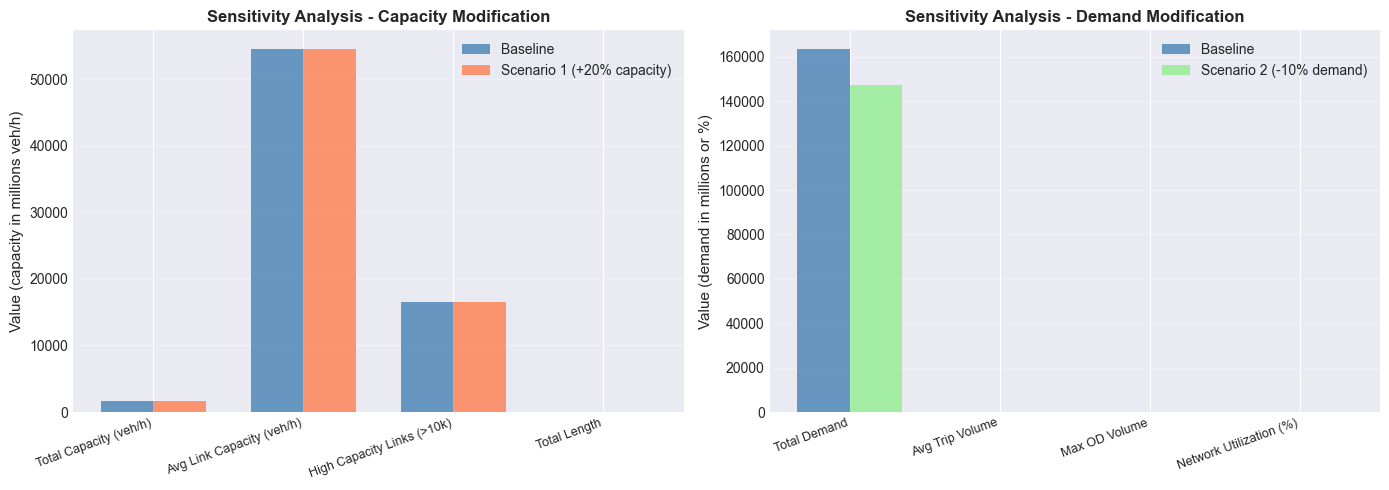


Sensitivity analysis framework complete.
This demonstrates how different scenarios affect network metrics.


In [28]:
# Sensitivity Analysis: Test how network metrics change with link modifications
print("="*70)
print("SENSITIVITY ANALYSIS - NETWORK MODIFICATION SCENARIOS")
print("="*70)

print("\nThis analysis demonstrates how network performance metrics respond to changes.")
print("Scenario: Increase capacity on high-volume links by 20%")
print()

try:
    # Define baseline metrics
    baseline_metrics = {
        'Total Capacity (veh/h)': links_df['capacity'].sum(),
        'Avg Link Capacity (veh/h)': links_df['capacity'].mean(),
        'High Capacity Links (>10k)': (links_df['capacity'] > 10000).sum(),
        'Total Length': links_df['length'].sum(),
    }

    # Scenario 1: Increase capacity on top 10% of links by volume
    scenario1_links = links_df.copy()
    high_volume_threshold = scenario1_links['capacity'].quantile(0.9)
    mask = scenario1_links['capacity'] > high_volume_threshold
    scenario1_links.loc[mask, 'capacity'] *= 1.2

    scenario1_metrics = {
        'Total Capacity (veh/h)': scenario1_links['capacity'].sum(),
        'Avg Link Capacity (veh/h)': scenario1_links['capacity'].mean(),
        'High Capacity Links (>10k)': (scenario1_links['capacity'] > 10000).sum(),
        'Total Length': scenario1_links['length'].sum(),
    }

    # Calculate changes
    print("\nBASELINE METRICS:")
    for metric, value in baseline_metrics.items():
        if 'Link' in metric or 'Length' in metric:
            print(f"  {metric:30s}: {value:15,.0f}")
        else:
            print(f"  {metric:30s}: {value:15,.0f}")

    print("\nSCENARIO 1: Increase capacity on top 10% links by 20%")
    print(f"  Links modified: {mask.sum()}")
    print(f"  Capacity threshold: {high_volume_threshold:,.0f} veh/h")

    print("\nSCENARIO 1 METRICS:")
    for metric, value in scenario1_metrics.items():
        baseline_value = baseline_metrics[metric]
        change_pct = 100 * (value - baseline_value) / baseline_value
        if 'Link' in metric or 'Length' in metric:
            print(f"  {metric:30s}: {value:15,.0f} ({change_pct:+.1f}%)")
        else:
            print(f"  {metric:30s}: {value:15,.0f} ({change_pct:+.1f}%)")

    # Scenario 2: Reduce demand by 10%
    demand_scenario2 = demand_df.copy()
    demand_scenario2['volume'] *= 0.9

    scenario2_metrics = {
        'Total Demand': demand_scenario2['volume'].sum(),
        'Avg Trip Volume': demand_scenario2['volume'].mean(),
        'Max OD Volume': demand_scenario2['volume'].max(),
        'Network Utilization (%)': (demand_scenario2['volume'].sum() / links_df['capacity'].sum()) * 100,
    }

    baseline_scenario2 = {
        'Total Demand': demand_df['volume'].sum(),
        'Avg Trip Volume': demand_df['volume'].mean(),
        'Max OD Volume': demand_df['volume'].max(),
        'Network Utilization (%)': (demand_df['volume'].sum() / links_df['capacity'].sum()) * 100,
    }

    print("\n\nSCENARIO 2: Reduce demand by 10%")
    print("\nBASELINE DEMAND:")
    for metric, value in baseline_scenario2.items():
        if '%' in metric:
            print(f"  {metric:30s}: {value:15.2f}%")
        else:
            print(f"  {metric:30s}: {value:15,.0f}")

    print("\nSCENARIO 2 (Demand -10%):")
    for metric, value in scenario2_metrics.items():
        baseline_value = baseline_scenario2[metric]
        change_pct = 100 * (value - baseline_value) / baseline_value
        if '%' in metric:
            print(f"  {metric:30s}: {value:15.2f}% ({change_pct:+.1f}%)")
        else:
            print(f"  {metric:30s}: {value:15,.0f} ({change_pct:+.1f}%)")

    # Visualization of sensitivity scenarios
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scenario 1: Capacity changes
    metrics_names = list(baseline_metrics.keys())
    baseline_values = [v/1e6 if v > 1e6 else v for v in baseline_metrics.values()]  # Normalize for visualization
    scenario1_values = [v/1e6 if v > 1e6 else v for v in scenario1_metrics.values()]

    x = np.arange(len(metrics_names))
    width = 0.35

    bars1 = axes[0].bar(x - width/2, baseline_values, width, label='Baseline', color='steelblue', alpha=0.8)
    bars2 = axes[0].bar(x + width/2, scenario1_values, width, label='Scenario 1 (+20% capacity)', color='coral', alpha=0.8)

    axes[0].set_ylabel('Value (capacity in millions veh/h)', fontsize=11)
    axes[0].set_title('Sensitivity Analysis - Capacity Modification', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_names, rotation=20, ha='right', fontsize=9)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Scenario 2: Demand changes
    demand_names = list(baseline_scenario2.keys())
    baseline_demand = list(baseline_scenario2.values())
    scenario2_demand = list(scenario2_metrics.values())

    x2 = np.arange(len(demand_names))
    bars3 = axes[1].bar(x2 - width/2, baseline_demand, width, label='Baseline', color='steelblue', alpha=0.8)
    bars4 = axes[1].bar(x2 + width/2, scenario2_demand, width, label='Scenario 2 (-10% demand)', color='lightgreen', alpha=0.8)

    axes[1].set_ylabel('Value (demand in millions or %)', fontsize=11)
    axes[1].set_title('Sensitivity Analysis - Demand Modification', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x2)
    axes[1].set_xticklabels(demand_names, rotation=20, ha='right', fontsize=9)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("Sensitivity analysis framework complete.")
    print("This demonstrates how different scenarios affect network metrics.")
    print("="*70)

except Exception as e:
    print(f"\nSensitivity analysis error: {e}")
    import traceback
    traceback.print_exc()